In [7]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import numpy as np
import pickle
import matplotlib.pyplot as plt
import sys
import json
from numpy import linalg as LA

import tensorflow as tf

import getpass
ui = getpass.getuser()
if ui == 'laura':
    p = '/home/laura'
elif ui == 'lauradriscoll':
    p = '/Users/lauradriscoll/Documents'

net = 'transfer_learn'
PATH_YANGNET = os.path.join(p,'code/multitask-nets',net) 

sys.path.insert(0, PATH_YANGNET)
from task import generate_trials, rule_name, rule_index_map, rules_dict
from network import Model, get_perf, FixedPoint_Model
import tools
from analysis import clustering, standard_analysis, variance
import numpy.random as npr
from tools_lnd import var_ex_X_task, get_model_params, gen_trial_set,gen_trials_from_model_dir,remove_spines
from tools_lnd import make_FP_axs,interp_h_tasks_w_context, get_filename, interp3d
from tools_lnd import gen_D_fp_qr
from sklearn.decomposition import PCA

In [8]:
figpath = os.path.join(p,'code','overleaf','multitask-nets','online_figs','fig6','fig6_BEIMQ')
if not os.path.exists(figpath):
    os.makedirs(figpath)

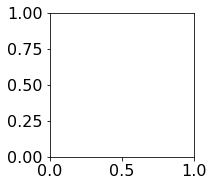

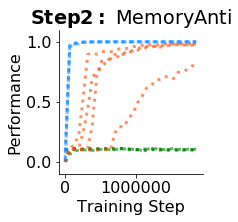

In [17]:
fig = plt.figure(figsize=(2, 2)) #7,2
plt.rcParams.update({'font.size': 16})
ax_post = fig.add_axes([0,0,1,1])
n_steps = 30

rnn_type = 'LeakyRNN'
activation = 'softplus'
w_init = 'diag'
n_rnn = str(256)
l2w = -6
l2h = -6
l1w = 0
l1h = 0
seed = str(1)
lr = -7
data_folder = 'data_share/rnn/multitask/transfer_learn/final/'
post_train = 'delayanti'

c_set = {'pro_small':'orangered','mem_anti_motifs':'dodgerblue','all':'k','untrained':'g'}
labels = {'pro_small':'DelayPro, MemoryPro',
          'mem_anti_motifs':'DelayAnti, MemoryPro',
          'all':'All tasks except MemoryAnti',
          'untrained':'No pre-training'}

fig = plt.figure(figsize=(2, 2)) #7,2
plt.rcParams.update({'font.size': 16})
ax_post = fig.add_axes([0,0,1,1])

for ruleset in ['untrained','pro_small','mem_anti_motifs']:#'all',

    task_set = rules_dict[ruleset]
    if ruleset=='all':
        task_set = ['fdgo','reactgo','delaygo','fdanti','reactanti','delayanti','delaydm1','delaydm2',
                    'contextdelaydm1','contextdelaydm2','multidelaydm','dmsgo','dmsnogo','dmcgo','dmcnogo']
        task_set.pop(5)
    rule_trains_str = '_'.join(task_set)
    n_tasks = str(len(task_set))

    net_name = 'lr'+"{:.1f}".format(-lr)+'l2_w'+"{:.1f}".format(-l2w)+'_h'+"{:.1f}".format(-l2h)+'_'+rule_trains_str
    
    for seed_ind in range(4):
        
        
        seed=str(seed_ind)
        m = os.path.join(p,data_folder,rnn_type,activation,w_init,ruleset,n_tasks+'_tasks',n_rnn+'_n_rnn',net_name,'post_train_'+post_train,seed)
#         pre_m = os.path.join(p,'data/rnn/multitask/stepnet/final',ruleset,rnn_type,activation,w_init,
#                          n_tasks+'_tasks',n_rnn+'_n_rnn',net_name,seed)
        
#         print(pre_m)

        plt.sca(ax_post)
        with open(os.path.join(m,'log.json'), 'r') as f:
            log_post = json.load(f)
        rule = 'delayanti'
        plt.plot(log_post['trials'][:n_steps],(log_post['perf_'+rule][:n_steps]),':',c = c_set[ruleset],
                 alpha = .6,linewidth = 3,label = 'single task network')
        ax_post.set_xlabel('Training Step')
        ax_post.set_ylabel('Performance')
        ax_post.set_title(r"$\bf{Step 2 :}$"+' MemoryAnti')
        ax_post.spines['top'].set_visible(False)
        ax_post.spines['right'].set_visible(False)
        plt.ylim([-.1,1.1])

    figname = 'cost_transfer_pre_post'
    plt.savefig(os.path.join(figpath,figname+ruleset+'.pdf'),bbox_inches = 'tight')

In [18]:
model = Model(m)
with tf.Session() as sess:
    model.restore()
    model._sigma=0
    var_list = model.var_list
    params = [sess.run(var) for var in var_list]
    hparams = model.hp

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel_input_delayanti:0' shape=(1, 256) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data_share/rnn/multitask/transfer_learn/final/LeakyRNN/softplus/diag/mem_anti_motifs/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_fdanti/post_train_delayanti/3/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data_share/rnn/multitask/transfer_learn/final/LeakyRNN/softplus/diag/mem_anti_motifs/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_fdanti/post_train_delayanti/3/model.ckpt


In [19]:
m

'/Users/lauradriscoll/Documents/data_share/rnn/multitask/transfer_learn/final/LeakyRNN/softplus/diag/mem_anti_motifs/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_fdanti/post_train_delayanti/3'

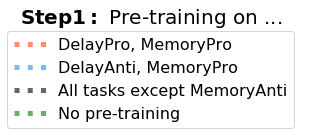

In [20]:
fig = plt.figure(figsize=(.1, .1)) #7,2
plt.rcParams.update({'font.size': 16})
ax = plt.subplot(111)

for ruleset in ['pro_small','mem_anti_motifs','all','untrained']:
    plt.plot(0,0,':',c =c_set[ruleset],alpha = .6,linewidth = 5,label = labels[ruleset])

plt.text(-5.5,.1,r"$\bf{Step 1 :}$"+' Pre-training on ... ', Fontsize = 20)
plt.legend(bbox_to_anchor=(0, .6, 1, 1))
remove_spines(ax)
ax.set_yticks([])
ax.set_xticks([])

figname = 'perf legend'
plt.savefig(os.path.join(figpath,figname+'.pdf'),bbox_inches = 'tight')
plt.savefig(os.path.join(figpath,figname+'.png'),bbox_inches = 'tight')

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel_input_delayanti:0' shape=(1, 256) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data_share/rnn/multitask/transfer_learn/final/LeakyRNN/softplus/diag/mem_anti_motifs/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_fdanti/post_train_delayanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data_share/rnn/multitask/transfer_learn/final/LeakyRNN/softplus/diag/mem_anti_motifs/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_fdanti/post_train_delayanti/0/model.ckpt
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel_input_delayanti:0' shape=(1, 256) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data_share/rnn/multitask/transfer_learn/final/LeakyRNN/softplus/diag/mem_anti_motifs/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_fdanti/post_train_delayanti/0/model.ckpt
Model resto

/usr/local/Caskroom/miniconda/base/envs/tensorflow/lib/python2.7/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


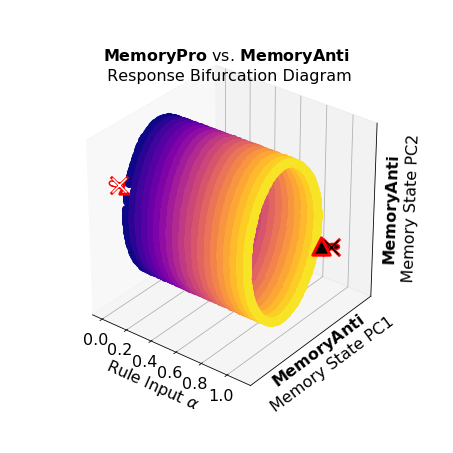

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel_input_delayanti:0' shape=(1, 256) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data_share/rnn/multitask/transfer_learn/final/LeakyRNN/softplus/diag/mem_anti_motifs/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_fdanti/post_train_delayanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data_share/rnn/multitask/transfer_learn/final/LeakyRNN/softplus/diag/mem_anti_motifs/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_fdanti/post_train_delayanti/0/model.ckpt
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel_input_delayanti:0' shape=(1, 256) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data_share/rnn/multitask/transfer_learn/final/LeakyRNN/softplus/diag/mem_anti_motifs/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_fdanti/post_train_delayanti/0/model.ckpt
Model resto

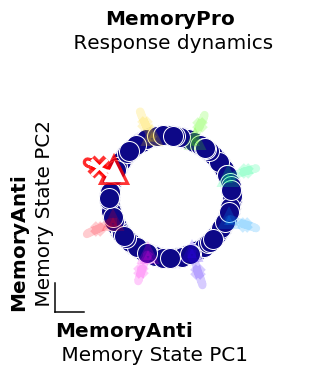

k
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel_input_delayanti:0' shape=(1, 256) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data_share/rnn/multitask/transfer_learn/final/LeakyRNN/softplus/diag/mem_anti_motifs/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_fdanti/post_train_delayanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data_share/rnn/multitask/transfer_learn/final/LeakyRNN/softplus/diag/mem_anti_motifs/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_fdanti/post_train_delayanti/0/model.ckpt
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel_input_delayanti:0' shape=(1, 256) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data_share/rnn/multitask/transfer_learn/final/LeakyRNN/softplus/diag/mem_anti_motifs/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_fdanti/post_train_delayanti/0/model.ckpt
Model res

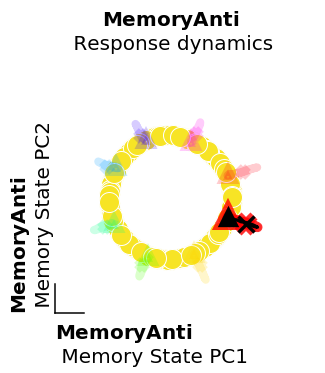

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel_input_delayanti:0' shape=(1, 256) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data_share/rnn/multitask/transfer_learn/final/LeakyRNN/softplus/diag/mem_anti_motifs/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_fdanti/post_train_delayanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data_share/rnn/multitask/transfer_learn/final/LeakyRNN/softplus/diag/mem_anti_motifs/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_fdanti/post_train_delayanti/0/model.ckpt
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel_input_delayanti:0' shape=(1, 256) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data_share/rnn/multitask/transfer_learn/final/LeakyRNN/softplus/diag/mem_anti_motifs/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_fdanti/post_train_delayanti/0/model.ckpt
Model resto

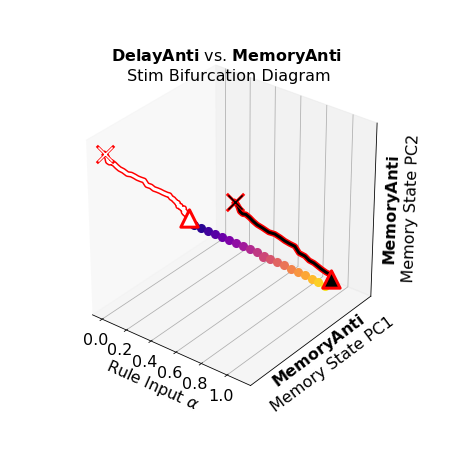

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel_input_delayanti:0' shape=(1, 256) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data_share/rnn/multitask/transfer_learn/final/LeakyRNN/softplus/diag/mem_anti_motifs/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_fdanti/post_train_delayanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data_share/rnn/multitask/transfer_learn/final/LeakyRNN/softplus/diag/mem_anti_motifs/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_fdanti/post_train_delayanti/0/model.ckpt
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel_input_delayanti:0' shape=(1, 256) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data_share/rnn/multitask/transfer_learn/final/LeakyRNN/softplus/diag/mem_anti_motifs/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_fdanti/post_train_delayanti/0/model.ckpt
Model resto

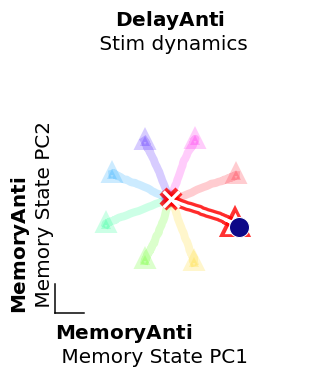

k
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel_input_delayanti:0' shape=(1, 256) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data_share/rnn/multitask/transfer_learn/final/LeakyRNN/softplus/diag/mem_anti_motifs/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_fdanti/post_train_delayanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data_share/rnn/multitask/transfer_learn/final/LeakyRNN/softplus/diag/mem_anti_motifs/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_fdanti/post_train_delayanti/0/model.ckpt
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel_input_delayanti:0' shape=(1, 256) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data_share/rnn/multitask/transfer_learn/final/LeakyRNN/softplus/diag/mem_anti_motifs/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_fdanti/post_train_delayanti/0/model.ckpt
Model res

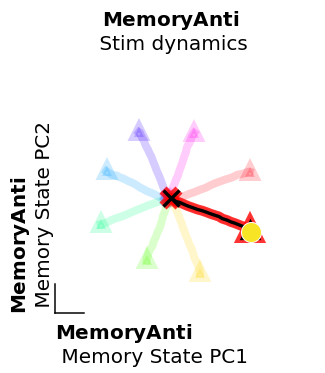

In [21]:
from tools_lnd import gen_trial_set,bifurc,plot_bifurc_ends, take_names
ruleset = 'mem_anti_motifs'
ax_labels = 'pca_h'
fig_size = 6
cmap_discrete = ['w','k']

task_set = rules_dict[ruleset]
if ruleset=='all':
    task_set = ['fdgo','reactgo','delaygo','fdanti','reactanti','delayanti','delaydm1','delaydm2',
                'contextdelaydm1','contextdelaydm2','multidelaydm','dmsgo','dmsnogo','dmcgo','dmcnogo']
    task_set.pop(5)
rule_trains_str = '_'.join(task_set)
n_tasks = str(len(task_set))

net_name = 'lr'+"{:.1f}".format(-lr)+'l2_w'+"{:.1f}".format(-l2w)+'_h'+"{:.1f}".format(-l2h)+'_'+rule_trains_str
seed = '0'
m = os.path.join(p,data_folder,rnn_type,activation,w_init,ruleset,n_tasks+'_tasks',n_rnn+'_n_rnn',net_name,'post_train_'+post_train,seed)

# rule_set = ['delaygo','delayanti']
# epoch_set = ['delay1','delay1']
# t_set = [0,0]
# ri_axs = 1
# epoch = epoch_set[ri_axs]
# rule = rule_set[ri_axs]
# trial = gen_trials_from_model_dir(m,rule,noise_on = False)
# filename,_ = get_filename(trial,epoch,0)
# f = os.path.join(m,'tf_fixed_pts_all_init',rule,filename+'.npz')
# D_use = make_FP_axs(f, m, rule, epoch, axs = 'pca_h', clust = 'False')
# w_in, b_in, w_out, b_out = get_model_params(m)
# D_use[:,2] = w_out[:,1]

# interp = False

rule_set = [2,5]
# rule_set = [rules_dict['all'][ri_set[0]],rules_dict['all'][ri_set[1]]]
epoch_set = ['delay1','delay1']
t_set = [0,0]
rule_axs = 1
epoch = epoch_set[rule_axs]
rule = rules_dict['all'][rule_set[rule_axs]]
trial = gen_trials_from_model_dir(m,rule,noise_on = False)
filename,_ = get_filename(trial,epoch,0)
f = os.path.join(m,'tf_fixed_pts_all_init',rule,filename+'.npz')
D_use = make_FP_axs(f, m, rule, epoch, axs = ax_labels, clust = 'False')
w_in, b_in, w_out, b_out = get_model_params(m)

D_use[:,0] = -D_use[:,0]
D_use[:,2] = w_out[:,2]

epoch_name_ax, rule_name_ax, _, _ = take_names(epoch,rule)
ax_labels = {}
ax_labels[1] = r"$\bf{"+rule_name_ax+"}$"+' \n '+epoch_name_ax+' State PC1'
ax_labels[2] = r"$\bf{"+rule_name_ax+"}$"+' \n '+epoch_name_ax+' State PC2'
ax_labels[0] = r"Rule Input $\alpha$"

interp = False
script_name = 'interp_tasks_small_init_mov_transfer'
tol_q = 1e-6
q_thresh = 1e-7

# bifurc(m,D_use,rule_set,epoch_set,t_set,script_name = script_name,tol_q = tol_q,cmap_discrete = cmap_discrete,
#      q_thresh = q_thresh,rule_axs = rule_axs, plot_unstable = True,title_y = .9,
#      n_skip_interps=1,color_stim = True,fig_size = fig_size,fontsize = 16, threeD = True,
#      figpath = figpath,ruleset = ruleset,ax_labels = ax_labels, stability_thresh = 2, 
#                    lims = [], view_ang = [31,-52])

# plot_bifurc_ends(m,D_use,rule_set,epoch_set,script_name, lims = [],fac_mult_lims = 2,fp_first = True, 
#                  q_thresh = q_thresh,stability_thresh = 2, color_stim = True, figpath = figpath, ruleset = ruleset)

epoch_set = ['go1','go1']
t_set = [0,0]

bifurc(m,D_use,rule_set,epoch_set,t_set,script_name = script_name,tol_q = tol_q,cmap_discrete = cmap_discrete,
     q_thresh = q_thresh,rule_axs = rule_axs, plot_unstable = True,title_y = .9,
     n_skip_interps=1,color_stim = True,fig_size = fig_size,fontsize = 16, threeD = True,
     figpath = figpath,ruleset = ruleset,ax_labels = ax_labels, stability_thresh = 2, 
                   lims = [], view_ang = [31,-52])

plot_bifurc_ends(m,D_use,rule_set,epoch_set,script_name, lims = [],fac_mult_lims = 2,fp_first = True, 
                 q_thresh = q_thresh,stability_thresh = 2, color_stim = True, figpath = figpath, 
                 ruleset = ruleset,ax_labels = [ax_labels[1],ax_labels[2]])

rule_set = [3,5]
trial_set = gen_trial_set(m,rule_set)
D_fp_qr = gen_D_fp_qr(m,trial_set,rule_axs,['fix1','fix1'],t_set)
D_use[:,2] = D_fp_qr[:,0]

epoch_set = ['stim1','stim1']
t_set = [0,0]

q_thresh = 1e-9

bifurc(m,D_use,rule_set,epoch_set,t_set,script_name = script_name,tol_q = tol_q,cmap_discrete = cmap_discrete,
     q_thresh = q_thresh,rule_axs = rule_axs, plot_unstable = True,title_y = .9,
     n_skip_interps=1,color_stim = True,fig_size = fig_size,fontsize = 16, threeD = True,
     figpath = figpath,ruleset = ruleset,ax_labels = ax_labels, stability_thresh = 1, 
                   lims = [], view_ang = [31,-52])

plot_bifurc_ends(m,D_use,rule_set,epoch_set,script_name, lims = [],fac_mult_lims = 2,fp_first = False, 
                 q_thresh = q_thresh,stability_thresh = 1, color_stim = True, figpath = figpath, 
                 ruleset = ruleset,ax_labels = [ax_labels[1],ax_labels[2]])


0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel_input_delayanti:0' shape=(1, 256) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/transfer_learn/final/LeakyRNN/softplus/diag/pro_small/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_delaygo/post_train_delayanti/1/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/transfer_learn/final/LeakyRNN/softplus/diag/pro_small/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_delaygo/post_train_delayanti/1/model.ckpt
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel_input_delayanti:0' shape=(1, 256) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/transfer_learn/final/LeakyRNN/softplus/diag/pro_small/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_delaygo/post_train_delayanti/1/model.ckpt
Model restored from file: /Users/lauradriscoll/Docume

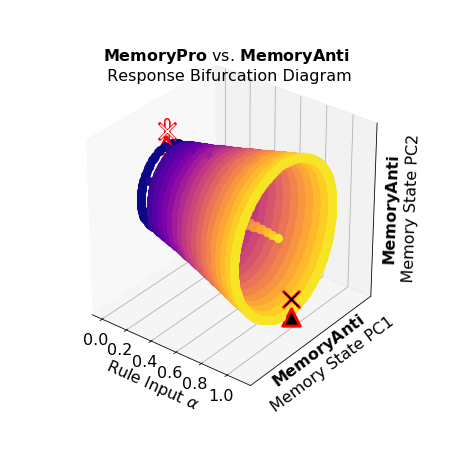

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel_input_delayanti:0' shape=(1, 256) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/transfer_learn/final/LeakyRNN/softplus/diag/pro_small/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_delaygo/post_train_delayanti/1/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/transfer_learn/final/LeakyRNN/softplus/diag/pro_small/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_delaygo/post_train_delayanti/1/model.ckpt
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel_input_delayanti:0' shape=(1, 256) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/transfer_learn/final/LeakyRNN/softplus/diag/pro_small/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_delaygo/post_train_delayanti/1/model.ckpt
Model restored from file: /Users/lauradriscoll/Docume

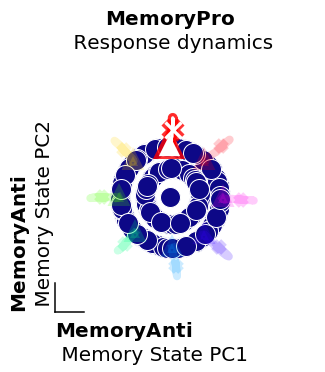

k
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel_input_delayanti:0' shape=(1, 256) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/transfer_learn/final/LeakyRNN/softplus/diag/pro_small/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_delaygo/post_train_delayanti/1/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/transfer_learn/final/LeakyRNN/softplus/diag/pro_small/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_delaygo/post_train_delayanti/1/model.ckpt
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel_input_delayanti:0' shape=(1, 256) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/transfer_learn/final/LeakyRNN/softplus/diag/pro_small/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_delaygo/post_train_delayanti/1/model.ckpt
Model restored from file: /Users/lauradriscoll/Docu

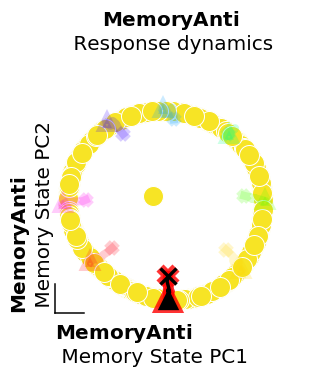

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel_input_delayanti:0' shape=(1, 256) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/transfer_learn/final/LeakyRNN/softplus/diag/pro_small/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_delaygo/post_train_delayanti/1/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/transfer_learn/final/LeakyRNN/softplus/diag/pro_small/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_delaygo/post_train_delayanti/1/model.ckpt
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel_input_delayanti:0' shape=(1, 256) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/transfer_learn/final/LeakyRNN/softplus/diag/pro_small/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_delaygo/post_train_delayanti/1/model.ckpt
Model restored from file: /Users/lauradriscoll/Docume

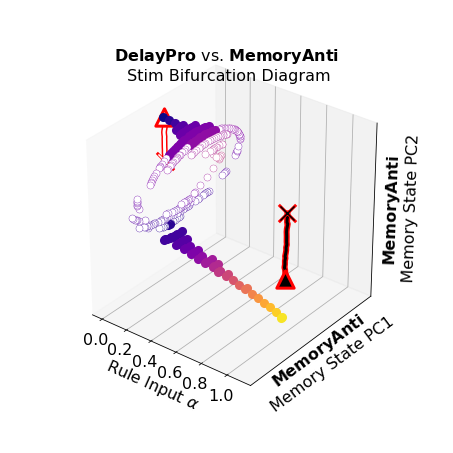

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel_input_delayanti:0' shape=(1, 256) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/transfer_learn/final/LeakyRNN/softplus/diag/pro_small/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_delaygo/post_train_delayanti/1/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/transfer_learn/final/LeakyRNN/softplus/diag/pro_small/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_delaygo/post_train_delayanti/1/model.ckpt
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel_input_delayanti:0' shape=(1, 256) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/transfer_learn/final/LeakyRNN/softplus/diag/pro_small/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_delaygo/post_train_delayanti/1/model.ckpt
Model restored from file: /Users/lauradriscoll/Docume

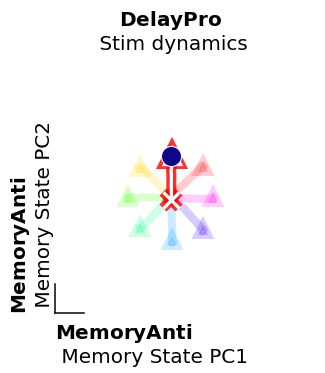

k
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel_input_delayanti:0' shape=(1, 256) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/transfer_learn/final/LeakyRNN/softplus/diag/pro_small/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_delaygo/post_train_delayanti/1/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/transfer_learn/final/LeakyRNN/softplus/diag/pro_small/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_delaygo/post_train_delayanti/1/model.ckpt
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel_input_delayanti:0' shape=(1, 256) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/transfer_learn/final/LeakyRNN/softplus/diag/pro_small/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_delaygo/post_train_delayanti/1/model.ckpt
Model restored from file: /Users/lauradriscoll/Docu

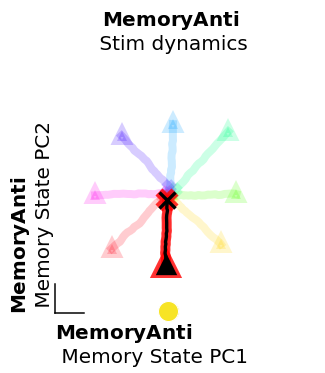

In [11]:
from tools_lnd import bifurc, plot_bifurc_ends, bifurc
fig_size = 6
ruleset = 'pro_small'
ax_labels = 'pca_h'
cmap_discrete = ['w','k']

task_set = rules_dict[ruleset]
if ruleset=='all':
    task_set = ['fdgo','reactgo','delaygo','fdanti','reactanti','delayanti','delaydm1','delaydm2',
                'contextdelaydm1','contextdelaydm2','multidelaydm','dmsgo','dmsnogo','dmcgo','dmcnogo']
    task_set.pop(5)
rule_trains_str = '_'.join(task_set)
n_tasks = str(len(task_set))

net_name = 'lr'+"{:.1f}".format(-lr)+'l2_w'+"{:.1f}".format(-l2w)+'_h'+"{:.1f}".format(-l2h)+'_'+rule_trains_str
seed = '1'
m = os.path.join(p,data_folder,rnn_type,activation,w_init,ruleset,n_tasks+'_tasks',n_rnn+'_n_rnn',net_name,'post_train_'+post_train,seed)

rule_set = [2,5]
# rule_set = [rules_dict['all'][ri_set[0]],rules_dict['all'][ri_set[1]]]
epoch_set = ['delay1','delay1']
t_set = [0,0]
rule_axs = 1
epoch = epoch_set[rule_axs]
rule = rules_dict['all'][rule_set[rule_axs]]
trial = gen_trials_from_model_dir(m,rule,noise_on = False)
filename,_ = get_filename(trial,epoch,0)
f = os.path.join(m,'tf_fixed_pts_all_init',rule,filename+'.npz')
D_use = make_FP_axs(f, m, rule, epoch, axs = ax_labels, clust = 'False')
w_in, b_in, w_out, b_out = get_model_params(m)

D_use[:,2] = w_out[:,2]

epoch_name_ax, rule_name_ax, _, _ = take_names(epoch,rule)
ax_labels = {}
ax_labels[1] = r"$\bf{"+rule_name_ax+"}$"+' \n '+epoch_name_ax+' State PC1'
ax_labels[2] = r"$\bf{"+rule_name_ax+"}$"+' \n '+epoch_name_ax+' State PC2'
ax_labels[0] = r"Rule Input $\alpha$"


interp = False
script_name = 'interp_tasks_small_init_mov_transfer'
tol_q = 1e-6
q_thresh = 1e-5


# bifurc(m,D_use,rule_set,epoch_set,t_set,script_name = script_name,tol_q = tol_q,cmap_discrete = cmap_discrete,
#      q_thresh = q_thresh,rule_axs = rule_axs, plot_unstable = True,title_y = .9,
#      n_skip_interps=1,color_stim = True,fig_size = fig_size,fontsize = 16, threeD = True,
#      figpath = figpath,ruleset = ruleset,ax_labels = ax_labels, stability_thresh = 2, 
#                    lims = [], view_ang = [31,-52])

# plot_bifurc_ends(m,D_use,rule_set,epoch_set,script_name, lims = [],fac_mult_lims = 2,fp_first = True, 
#                  q_thresh = q_thresh,stability_thresh = 2, color_stim = True, figpath = figpath, 
#                  ruleset = ruleset,ax_labels = [ax_labels[1],ax_labels[2]])

# bifurc(m,D_use,rule_set,epoch_set,rule_axs = rule_axs,ax_labels = ax_labels,script_name = script_name,
#            color_stim = True, fig_size = 6, fontsize = 20, figpath = figpath, ruleset = ruleset,
#            title_y = .9, n_trials = 8, stability_thresh = 2, threeD = True,cmap_discrete =  cmap_discrete,
#            lw = 10,ms = 10,linestyle = '-',al_state = 1,al_fp = .1, 
#            bifurc = False, plot_zero_plane = True)

rule_set = [2,5]
epoch_set = ['go1','go1']
t_set = [0,0]

bifurc(m,D_use,rule_set,epoch_set,t_set,script_name = script_name,tol_q = tol_q,cmap_discrete = cmap_discrete,
     q_thresh = q_thresh,rule_axs = rule_axs, plot_unstable = True,title_y = .9,
     n_skip_interps=1,color_stim = True,fig_size = fig_size,fontsize = 16, threeD = True,
     figpath = figpath,ruleset = ruleset,ax_labels = ax_labels, stability_thresh = 2, 
                   lims = [], view_ang = [31,-52])

plot_bifurc_ends(m,D_use,rule_set,epoch_set,script_name, lims = [],fac_mult_lims = 2,fp_first = True, 
                 q_thresh = q_thresh,stability_thresh = 2, color_stim = True, figpath = figpath, 
                 ruleset = ruleset,ax_labels = [ax_labels[1],ax_labels[2]])

# bifurc(m,D_use,rule_set,epoch_set,rule_axs = rule_axs,ax_labels = ax_labels,script_name = script_name,
#            color_stim = True, fig_size = 6, fontsize = 20, figpath = figpath, ruleset = ruleset,
#            title_y = .9, n_trials = 8, stability_thresh = 2, threeD = True,cmap_discrete = cmap_discrete,
#            lw = 10,ms = 10,linestyle = '-',al_state = 1,al_fp = 0, 
#            bifurc = False, plot_zero_plane = True)

rule_set = [0,5]
trial_set = gen_trial_set(m,rule_set)
D_fp_qr = gen_D_fp_qr(m,trial_set,rule_axs,['fix1','fix1'],t_set)
D_use[:,2] = D_fp_qr[:,0]

epoch_set = ['stim1','stim1']
t_set = [0,0]
script_name = 'interp_tasks_small_init_stim_transfer'

q_thresh = 1e-7

# bifurc(m,D_use,rule_set,epoch_set,t_set,script_name = script_name,tol_q = tol_q,cmap_discrete = cmap_discrete,
#      q_thresh = q_thresh,rule_axs = rule_axs, plot_unstable = True,title_y = .9,
#      n_skip_interps=1,color_stim = True,fig_size = fig_size,fontsize = 16, threeD = True,
#      figpath = figpath,ruleset = ruleset,ax_labels = ax_labels, stability_thresh = 1, 
#                    lims = [], view_ang = [31,-52])

# plot_bifurc_ends(m,D_use,rule_set,epoch_set,script_name, lims = [],fac_mult_lims = 2,fp_first = False, 
#                  q_thresh = q_thresh,stability_thresh = 1, color_stim = True, figpath = figpath, ruleset = ruleset)

# script_name = 'interp_tasks_small_init_mov_transfer'

bifurc(m,D_use,rule_set,epoch_set,t_set,script_name = script_name,tol_q = tol_q,cmap_discrete = cmap_discrete,
     q_thresh = q_thresh,rule_axs = rule_axs, plot_unstable = True,title_y = .9,
     n_skip_interps=1,color_stim = True,fig_size = fig_size,fontsize = 16, threeD = True,
     figpath = figpath,ruleset = ruleset,ax_labels = ax_labels, stability_thresh = 1, 
                   lims = [], view_ang = [31,-52])

plot_bifurc_ends(m,D_use,rule_set,epoch_set,script_name, lims = [],fac_mult_lims = 2,fp_first = False, 
                 q_thresh = q_thresh,stability_thresh = 1, color_stim = True, figpath = figpath, 
                 ruleset = ruleset,ax_labels = [ax_labels[1],ax_labels[2]])

# bifurc(m,D_use,rule_set,epoch_set,rule_axs = rule_axs,ax_labels = ax_labels,script_name = script_name,
#            color_stim = True, fig_size = 6, fontsize = 20, figpath = figpath, ruleset = ruleset,
#            title_y = .9, n_trials = 8, stability_thresh = 1, threeD = True,cmap_discrete = cmap_discrete,
#            lw = 10,ms = 10,linestyle = '-',al_state = 1,al_fp = 0, 
#            bifurc = False, plot_zero_plane = False)
